In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

## Helper Functions

In [2]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')


def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})



# Import the check_stationarity function from previous lab
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# Data

In [3]:
#Loading our dataset
df = pd.read_csv('data/zillow_data.csv')

In [4]:
#Observing what our dataset looks like
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


# Data Analysis

## Narrowing the scope of our project

Our client is looking to purchase a home in Florida. We want to identify the best 5 Zip Codes which we believe will have the highest ROI after 3 years of purchase. i.e. We want the zipcodes that we believe will appreciate the most in value. These predictions will be mades using Time Series modeling.

### Looking at our Florida data

In [5]:
#Dataframe containing only zips from Florida

florida =  df[df['State']=='FL']

In [6]:
#Observing what our Florida dataset looks like

florida

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,249900,250400,249900,248700,247500,247100,246800,247500,249800,251800
60,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0,337900.0,338300.0,...,1466200,1471000,1485400,1497700,1504200,1507600,1495800,1466200,1443900,1432300
82,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0,111700.0,111800.0,...,283500,286100,287800,288800,289700,291000,292500,294200,296400,298200
83,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0,126800.0,126800.0,...,297400,299300,301400,303300,304900,307100,309800,311700,312600,313100
84,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0,480700.0,481200.0,...,2917100,2925700,2942400,2958300,2946300,2912900,2900900,2923300,2933600,2914100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14250,73224,34797,Yalaha,FL,Orlando,Lake,14251,86100.0,86800.0,87400.0,...,174900,177100,179100,181500,184200,186200,187200,189000,191900,193500
14262,71852,32193,Welaka,FL,Palatka,Putnam,14263,53800.0,54100.0,54300.0,...,94400,99000,100800,101000,103000,105400,104900,106100,112600,118300
14315,72384,33051,Key Colony Beach,FL,Key West,Monroe,14316,202200.0,202800.0,203400.0,...,570200,564800,561100,557300,552300,545100,542300,551500,570900,585300
14558,72865,33855,Lake Wales,FL,Lakeland,Polk,14559,NaN,NaN,NaN,...,130400,131500,134800,137900,139400,140000,140000,140300,141900,143000


## Number of ZipCodes for each Metro in Florida

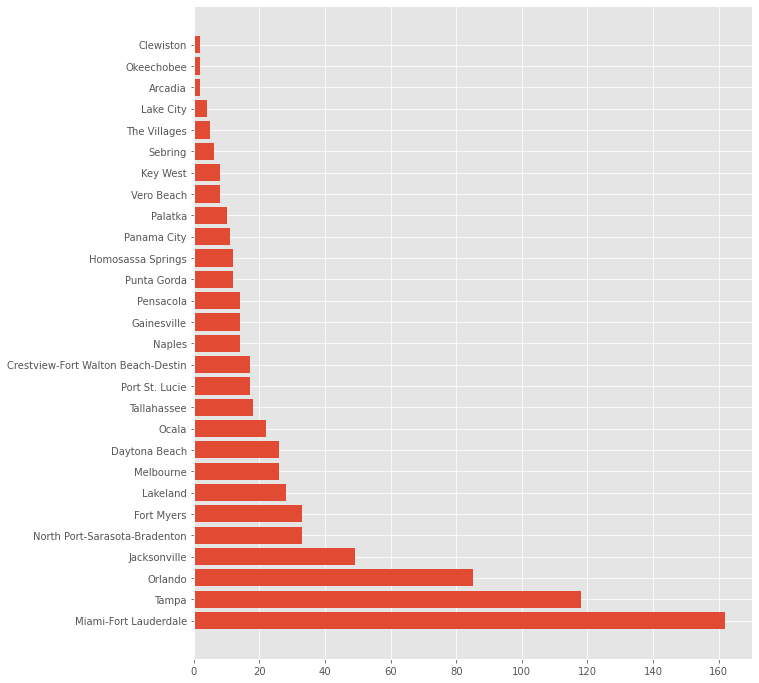

In [7]:
#Visualizing the value counts of zipcodes in each metro region in Florida

fig, ax = plt.subplots(figsize=(10,12))

y = [a for a in florida['Metro'].value_counts()]

x = [a for a in florida['Metro'].value_counts().keys()]

ax.barh(x,y);

We can see above that the Miami-Fort Lauderdale region has the highest number of zipcodes.

Our client is particularly interested in purchasing a property in the Miami-Fort Lauderdale metro region.

In [8]:
miami_metro = df[df['Metro']== 'Miami-Fort Lauderdale']

## Selecting a ZipCode to build our Time Series model on

We want to build a Time Series model to predict the future ROI for each zip code in Florida. But first, we will select one specific zipcode to build our time series model on. For this purpose, we decided to find the zipcode that has seen the highest growth in the 3 years since our last recorded date - April, 2018. i.e. We will find the zipcode which has grown the most between April, 2015 and April, 2018.

In [9]:
#Creating a new column that shows the 5 year increase in value. From April, 2013 to April, 2018.
warnings.filterwarnings('ignore')

miami_metro['3 yr ROI'] = None
miami_metro['3 yr ROI'] = miami_metro['2018-04'].apply(lambda x : x-miami_metro['2015-04'])

In [10]:
#Identifying the ZipCode that grew the most between April,2013 and April,2018.

roi_df = miami_metro[['RegionName','3 yr ROI']].sort_values('3 yr ROI',ascending = False)

print(f'Highest growing Zipcode since April 2015 is : {int(roi_df.iloc[0][0])}')

Highest growing Zipcode since April 2015 is : 33480


We will run our first Time Series model on the ZipCode- 33480 to predict what its future value will be. Then we can run a similar model on other zipcodes in the state to identify which 5 zipcodes have the highest predicted ROI.

In [11]:
#Dataframe containining historical prices of the 33480 Zip Code.

zip33480 = df[df['RegionName']==33480]

In [12]:
# Time Series dataframe of 33480 Zip Code prices

series33480 = melt_data(zip33480)

In [13]:
#Observing our Time Series dataframe

series33480

,value
time,
1996-04-01,958400.0
1996-05-01,958100.0
1996-06-01,957900.0
1996-07-01,957800.0
1996-08-01,958000.0
...,...
2017-12-01,4609000.0
2018-01-01,4626500.0
2018-02-01,4661200.0


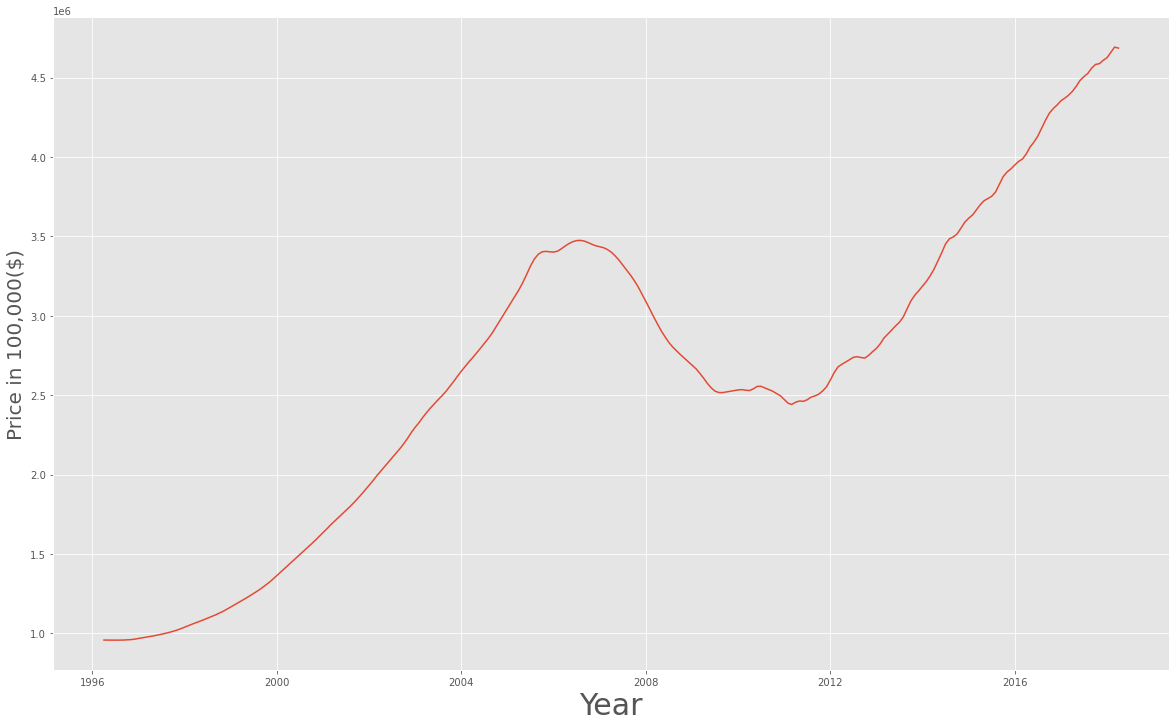

In [14]:
#Visualizing our Time Series Data

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(series33480)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20);

We can see from above that after several years of growth in the early years of the 21st Century, prices seemed to have likely fallen due to the economic crisis that emerged in 2008. Since around 2011 though, there has been a dramatic increase in prices.

# Data Pre-Processing

## Tests for Stationarity

Time series models commonly operate with the assumption that the time series is **stationary**. i.e. Over a longer period of time, the series tends not to have a trend or seasonal effects. This means that if a time series that displays a particular behavior over time, it is highly likely that it will replicate similar behavior in the future. We can perform some tests for **Stationarity** to show if the time series is stationary.

### Looking at the Rolling Statistics

In [15]:
roll_mean = series33480.rolling(window=8, center=False).mean()
roll_std = series33480.rolling(window=8, center=False).std()

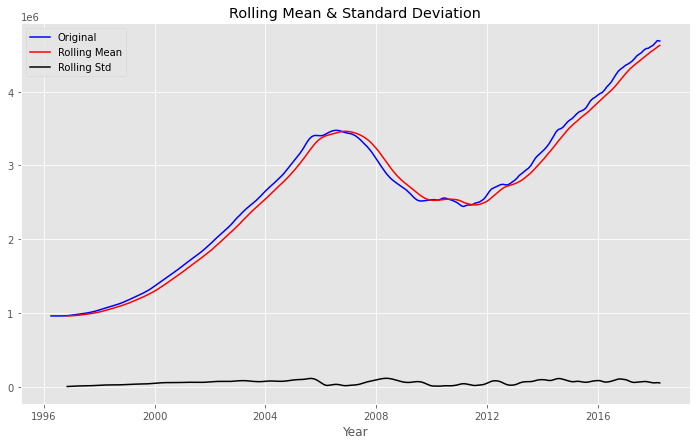

In [16]:
fig = plt.figure(figsize=(12,7))
plt.plot(series33480, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.show(block=False)

We can see that our rolling mean increases over time. This means that our time series data is not stationary.

### The Dickey-Fuller Test

Let's perform a Dickey-Fuller test to prove statistically that the time series is not stationary. For the Dickey-Fuller test, the null hypothesis is that the time series is not stationary. Therefore, in order to reject the null hypothesis, we will want a p-value of less than 0.05.

In [17]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series33480)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -1.741387
p-value                          0.409925
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


We can see from above that the test returned a p-value of 0.49. This is much higher than the 0.05 cutoff that was necessary to reject the null hypothesis. Therefore we fail to reject the null hypothesis and can conclude that the time series is not stationary. Of course this is quite intuitive just by looking at the graph, but it is always good practice to prove this statistically.

# Making our Time Series Stationary

As mentioned earlier, most models work under the assumption that the Time Series is stationary. Therefore we will need to make our current time series stationary. A common method that is used to eliminate this problem is **Differencing**.

## Differencing

Differencing is a common technique used to minimize the trend and seasonality in a non-stationary time series. In this method, we take the difference in values between a given instant and the instant that precedes it; thereby forming a 1-period lag.

In order to difference our time series, we will need to decide upon the best period value at which we want to do our differencing. Therefore we will perform a loop function to iterate over period values of 0 to 24 to find the smallest period that returns a p-value below 0.05.

In [18]:
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')

def differencer(data):
    for i in range(0,25):
        difference = data.diff(periods=i)
        dftest = adfuller(difference[i:])
        print(i,dftest[1])

differencer(series33480)

0 nan
1 0.343131540861913
2 0.45148878461964975
3 0.3498779332973291
4 0.2657516719792066
5 0.2619961261754454
6 0.30968491386363906
7 0.19910839223251842
8 0.2115094850164156
9 0.37267840416752657
10 0.08902492361440495
11 0.14508366097604297
12 0.17102021265075695
13 0.06528026593849018
14 0.03683844039720054
15 0.028217511106596708
16 0.20034873851597862
17 0.39427111907187
18 0.3923268584409646
19 0.08066468289972795
20 0.15143785859299064
21 0.0324766436581636
22 0.0827926852867667
23 0.02497432287830202
24 0.03767554534847937


We can see from the above results that a period value of 14 is the smallest period that returns a p-value of less than 0.05. Therefore this is the period value we will use to perform differencing on our time series.

In [19]:
#We use .dropna() to remove the first 14 values which will return NaN.
series_diff= series33480.diff(periods=14).dropna()

Now that we have a differenced time series, let us perform our tests to check for stationarity.

# Testing our Differenced Series for Stationarity

### Differenced Time Series Rolling Statistics

In [20]:
roll_mean_diff = series_diff.rolling(window=8, center=False).mean()
roll_std_diff = series_diff.rolling(window=8, center=False).std()

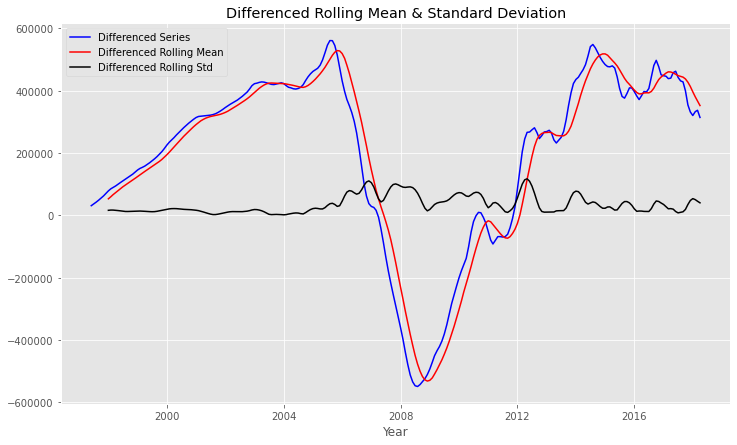

In [21]:
fig = plt.figure(figsize=(12,7))
plt.plot(series_diff, color='blue', label='Differenced Series')
plt.plot(roll_mean_diff, color='red', label='Differenced Rolling Mean')
plt.plot(roll_std_diff, color='black', label = 'Differenced Rolling Std')
plt.legend(loc='best')
plt.title('Differenced Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.show(block=False)

There is a significant drop in the rolling mean of our differenced series during the financial crisis that occurred in 2008. But the rolling mean picks back up to indicate possible stationarity over time. We can confirm this statistically by performing the Dickey-Fuller test.

### Dickey-Fuller Test on Differenced Time Series

Given that the null hypothesis is that the series is not stationary, we need a p-value of less than 0.05 to reject it.

In [22]:
dftest_diff = adfuller(series_diff)

# Extract and display test results in a user friendly manner
dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput_diff)

Results of Dickey-Fuller test: 

Test Statistic                  -2.979656
p-value                          0.036838
#Lags Used                      15.000000
Number of Observations Used    235.000000
dtype: float64


A p-value of 0.036838 is less than 0.05 and therefore we can reject the null hypothesis and conclude that the series is now stationary. This means that we can finally move to the next step. i.e. Modeling the time series.

# Modeling

For our SARIMAX model, we need to pass through the parameters- p,d & q. We will perform a GridSearch first to identify the best combination of parameter values that will give us the best fitting model.

In [23]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

We have set the possible values for p,d & q as either 0 or 1. This is because of computational constraints as running a grid search on combination possibilites that include more than 2 different types would take a very long time. i.e. With values of either 0 or 1, there are 8 different possible combinations of p,d & q. If we allowed a list of possible values for our p,d & q to include 3, we would have 27 different combinations. And if we include 4, there are 64 different combinations. Hence we are sticking to 1 & 2 as possible values due to exponentially higher computational effort.

In [24]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value

warnings.filterwarnings('ignore')

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(series33480,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
   

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =8594.017957867385
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =8050.561252899932
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =7069.664435094653
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =6648.48641393533
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =7012.447833655105
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =6923.948238861655
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =6478.600076599689
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =9417.203053980094
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =8370.328768896046
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =10533634.083422547
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =7246.666041658241
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =6936.618013250656
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7989.870010254088
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =9055292.218381006
ARIMA (0, 0, 1) x (1

Now that we have calcuted the AIC values for every possible combination, we can look at the combination that returns the lowest AIC value.

In [25]:
# Find the parameters with minimal AIC value

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           5016.72
Name: 59, dtype: object

# Fitting an ARIMA Model

From our work above, with the help of a grid search we were able to identify the best combination of p,d & q parameters that would gives us the best fitting model for us to make predictions from our time series data.

Let's plug in our p,d & q values to our model.

In [26]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(series33480, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7120      0.047     15.004      0.000       0.619       0.805
ma.L1          0.7287      0.036     20.358      0.000       0.659       0.799
ar.S.L12       0.1097      7.126      0.015      0.988     -13.857      14.077
ma.S.L12      -0.1124      7.115     -0.016      0.987     -14.058      13.833
sigma2      8.607e+07   4.29e-06   2.01e+13      0.000    8.61e+07    8.61e+07


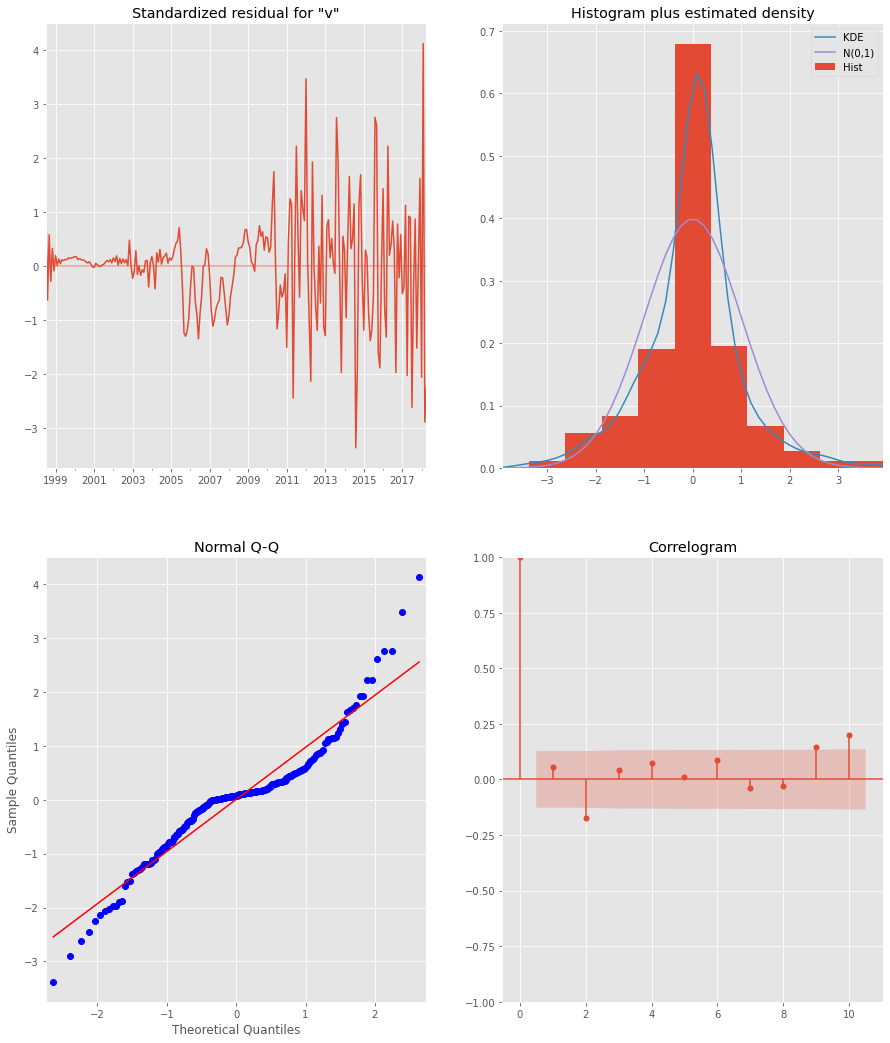

In [27]:
# Call plot_diagnostics() on the results calculated above 

output.plot_diagnostics(figsize=(15, 18))
plt.show()

We want to ensure that our residuals are uncorrelated, normally distributed and have zero mean. If not, we need to tweak our model further.

Let's check for these assumptions from diagnostics plots.

* Top-right plot - ????????????

* Our qq-plot shown on the bottom left displays that our residuals are somewhat following the linear trend line. This tells us that the residuals seen here are normally distributed.

* The autocorrelation plot on the bottom right, shows that the time series residuals have low correlation with lagged versions of itself.

????? These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [28]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2015-04-01'), dynamic=False)
pred_conf = pred.conf_int()

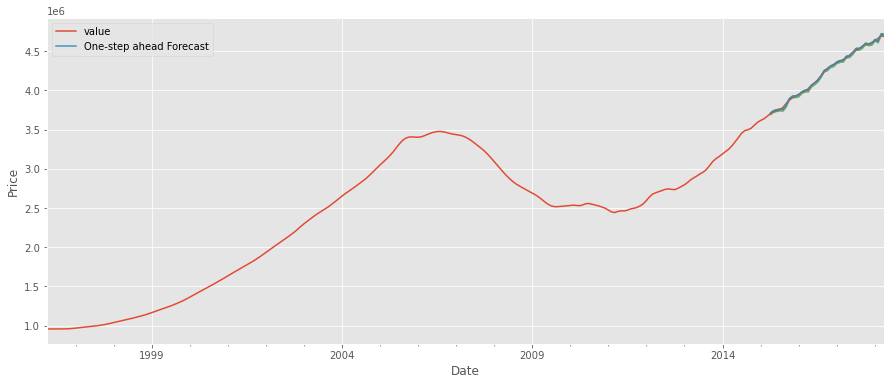

In [29]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = series33480.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [30]:
## Getting a forecast
forecast = output.get_forecast(36)
prediction = forecast.conf_int()
prediction['value'] = forecast.predicted_mean
prediction.columns = ['lower','upper','prediction'] 
prediction

,lower,upper,prediction
2018-05-01,4.662568e+06,4.698935e+06,4.680752e+06
2018-06-01,4.644242e+06,4.740165e+06,4.692203e+06
2018-07-01,4.617682e+06,4.776095e+06,4.696888e+06
2018-08-01,4.593827e+06,4.813807e+06,4.703817e+06
2018-09-01,4.588575e+06,4.867537e+06,4.728056e+06
2018-10-01,4.576974e+06,4.911714e+06,4.744344e+06
2018-11-01,4.550992e+06,4.938188e+06,4.744590e+06
2018-12-01,4.543733e+06,4.980192e+06,4.761963e+06
2019-01-01,4.535666e+06,5.018422e+06,4.777044e+06
2019-02-01,4.546781e+06,5.073137e+06,4.809959e+06


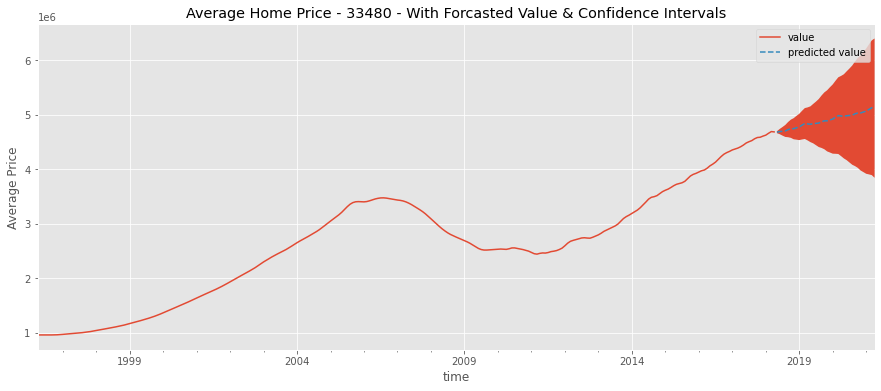

In [31]:
fig, ax = plt.subplots()
series33480.plot(ax=ax,label='values')


prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= prediction.index, y1= prediction['lower'], y2= prediction['upper'])
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 33480 - With Forcasted Value & Confidence Intervals')
plt.show()

# Modeling every Zip Code in Florida

In [32]:
#List of Zip Codes in the Miami-Fort Lauderdale metro region.
miami_metro_zips = [a for a in miami_metro['RegionName']]

In [33]:
zip_predictions = {}

for zipcode in miami_metro_zips:
    
    series = melt_data(df[df['RegionName']== zipcode])
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
    
    #Finding the combination of parameters with the smallest AIC value.
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    results = dict(ans_df.loc[ans_df['aic'].idxmin()])

    # Plug the optimal parameter values into a new SARIMAX model
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(series, 
                                            order= results['pdq'], 
                                            seasonal_order= results['pdqs'], 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    # Get predictions starting from and calculate confidence intervals
    pred = output.get_prediction(start=pd.to_datetime('2015-04-01'), dynamic=False)
    pred_conf = pred.conf_int()

    ## Getting a forecast
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    zip_predictions[zipcode]= prediction['prediction']




In [39]:
forecast_3yr = {}
for a in miami_metro_zips:
    forecast_3yr[a] = zip_predictions[a]['2021-04-01']

In [44]:
# 3 year forecast for zipcodes
sort_orders = sorted(forecast_3yr.items(), key=lambda x: x[1], reverse=True)

sorted_forecast_3yr = {}
for i in sort_orders:
	sorted_forecast_3yr[i[0]] = i[1]

In [45]:
# 3 year forecast for zipcodes arranged in descending order
sorted_forecast_3yr

{33480: 5119755.135312454,
 33139: 2850271.132267813,
 33316: 1739794.1248187127,
 33149: 1434588.1464815661,
 33301: 1411558.879681964,
 33140: 1401270.4501897444,
 33483: 1339875.7986123406,
 33146: 1138277.477862598,
 33160: 1106164.5112933854,
 33181: 1043381.7573750016,
 33156: 1026745.2913294804,
 33308: 987854.9115219432,
 33432: 951287.5983957556,
 33141: 920616.1692677088,
 33137: 918510.0807056832,
 33306: 891820.6006836335,
 33154: 872929.0617976137,
 33133: 862132.9465918966,
 33143: 859058.1583761028,
 33129: 817437.1084333922,
 33158: 768599.6270733313,
 33408: 765004.0342353266,
 33062: 745443.978249077,
 33180: 734045.0720456745,
 33332: 693310.7959336201,
 33138: 654348.7522435496,
 33019: 637391.4333821002,
 33477: 627241.393420264,
 33134: 626151.813931275,
 33076: 623830.4703661647,
 33469: 613379.995752197,
 33304: 600774.1957799139,
 33331: 593545.0799122585,
 33330: 583105.1581601446,
 33486: 552818.6587581572,
 33327: 552490.6855473269,
 33473: 550565.171606098,

In [49]:
top_5_zipcodes = list(sorted_forecast_3yr.items())[:5]

In [50]:
top_5_zipcodes

[(33480, 5119755.135312454),
 (33139, 2850271.132267813),
 (33316, 1739794.1248187127),
 (33149, 1434588.1464815661),
 (33301, 1411558.879681964)]